In [19]:
import numpy as np
import scipy.interpolate
import torch
from matplotlib import pyplot as plt


def bd_metric(R1, PSNR1, R2, PSNR2):
    lR1 = np.log(R1)
    lR2 = np.log(R2)

    PSNR1 = np.array(PSNR1)
    PSNR2 = np.array(PSNR2)

    # integration interval
    min_int = max(min(lR1), min(lR2))
    max_int = min(max(lR1), max(lR2))

    p1 = np.polyfit(lR1, PSNR1, 3)
    p2 = np.polyfit(lR2, PSNR2, 3)

    p_int1 = np.polyint(p1)
    p_int2 = np.polyint(p2)

    int1 = np.polyval(p_int1, max_int) - np.polyval(p_int1, min_int)
    int2 = np.polyval(p_int2, max_int) - np.polyval(p_int2, min_int)

    # find avg diff
    avg_diff = (int2 - int1) / (max_int - min_int)

    return avg_diff


def bd_rate(R1, PSNR1, R2, PSNR2):
    lR1 = np.log(R1)
    lR2 = np.log(R2)

    # integration interval
    min_int = max(min(PSNR1), min(PSNR2))
    max_int = min(max(PSNR1), max(PSNR2))


    p1 = np.polyfit(PSNR1, lR1, 3)
    p2 = np.polyfit(PSNR2, lR2, 3)

    p_int1 = np.polyint(p1)
    p_int2 = np.polyint(p2)

    int1 = np.polyval(p_int1, max_int) - np.polyval(p_int1, min_int)
    int2 = np.polyval(p_int2, max_int) - np.polyval(p_int2, min_int)

    # find avg diff
    avg_exp_diff = (int2 - int1) / (max_int - min_int)
    avg_diff = (np.exp(avg_exp_diff) - 1) * 100
    return avg_diff

In [18]:
import matplotlib


class Plot:
    def __init__(self, label):
        self.label = label

        self.fig, self.ax = plt.subplots(figsize=(30, 10))
        self.ax.ticklabel_format(style='plain')
        plt.rcParams['font.size'] = 12
        self.ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{int(x // 1000)} kbps"))
        plt.grid(True)

    def plot_entries(self, entries, label="None", steps=1000, color='r'):
        bitrates = list(entries.keys())
        psnrs = list(entries.values())
        min_bitrate, max_bitrate = min(bitrates), max(bitrates)

        xs, interval = np.linspace(min_bitrate, max_bitrate, num=steps, retstep=True)
        ys = scipy.interpolate.pchip_interpolate(bitrates, psnrs, xs)

        self.ax.plot(xs, ys, label=label)
        self.ax.legend()
        for bitrate, psnr in entries.items():
            self.ax.scatter(bitrate, psnr, s=50, zorder=10, marker="o", facecolors='none', edgecolors=color)

        plt.xlabel("bitrate")
        plt.ylabel(self.label)

In [17]:
from pathlib import Path
from src.dataset.util.directory_operations import calculate_average_bitrate_in_directory, \
    calculate_average_metric_in_directory, calculate_average_metric_in_directory_for_model


def process_bd_rates(model_input_clips, dbf_sao_clips, models, save_name, metric_func):
    model_input_bitrates = [calculate_average_bitrate_in_directory(path) for path in model_input_clips]
    dbf_sao_bitrates = [calculate_average_bitrate_in_directory(path) for path in dbf_sao_clips]

    dbf_sao_metrics = [calculate_average_metric_in_directory(path, metric_func) for path in dbf_sao_clips]
    pred_metrics = [
        calculate_average_metric_in_directory_for_model(path, model.eval().cuda(), metric_func)
        for path, model in zip(model_input_clips, models)
    ]

    no_deblocking_metrics = [calculate_average_metric_in_directory(path, metric_func) for path in model_input_clips]
    print(pred_metrics)
    print(dbf_sao_metrics)
    print(no_deblocking_metrics)


    pred_entries = dict(
        zip(model_input_bitrates, pred_metrics)
    )

    dbf_sao_entries = dict(
        zip(dbf_sao_bitrates, dbf_sao_metrics)
    )

    no_deblocking_entries = dict(
        zip(model_input_bitrates, no_deblocking_metrics)
    )

    ms_ssim_plot = Plot(save_name)
    ms_ssim_plot.plot_entries(pred_entries, "VFS-UNet")
    ms_ssim_plot.plot_entries(dbf_sao_entries, "DBF + SAO")
    ms_ssim_plot.plot_entries(no_deblocking_entries, "No filters")
    plt.savefig(f'images/{save_name}.png', bbox_inches='tight', pad_inches=0)
    plt.rcParams['font.size'] = 12
    plt.show()

    bitrates_pred = np.array(list(pred_entries.keys()))
    pred_metric = np.array(list(pred_entries.values()))
    dbf_sao_bitrates = np.array(list(dbf_sao_entries.keys()))
    dbf_sao_metric = np.array(list(dbf_sao_entries.values()))

    print(f"{save_name}:", bd_metric(dbf_sao_bitrates, dbf_sao_metric, bitrates_pred, pred_metric, piecewise=0))
    print(f"{save_name} BD-rate:", bd_rate(dbf_sao_bitrates, dbf_sao_metric, bitrates_pred, pred_metric, piecewise=0))

from torchmetrics.functional import psnr
from pytorch_msssim import ms_ssim

100%|██████████| 1564/1564 [00:06<00:00, 225.67it/s]


[tensor(32.2014, dtype=torch.float64), tensor(33.2133, dtype=torch.float64), tensor(34.2952, dtype=torch.float64), tensor(35.9185, dtype=torch.float64)]
[tensor(31.6979, dtype=torch.float64), tensor(32.6257, dtype=torch.float64), tensor(33.7627, dtype=torch.float64), tensor(35.3414, dtype=torch.float64)]
[tensor(31.4083, dtype=torch.float64), tensor(32.3352, dtype=torch.float64), tensor(33.4647, dtype=torch.float64), tensor(35.0739, dtype=torch.float64)]


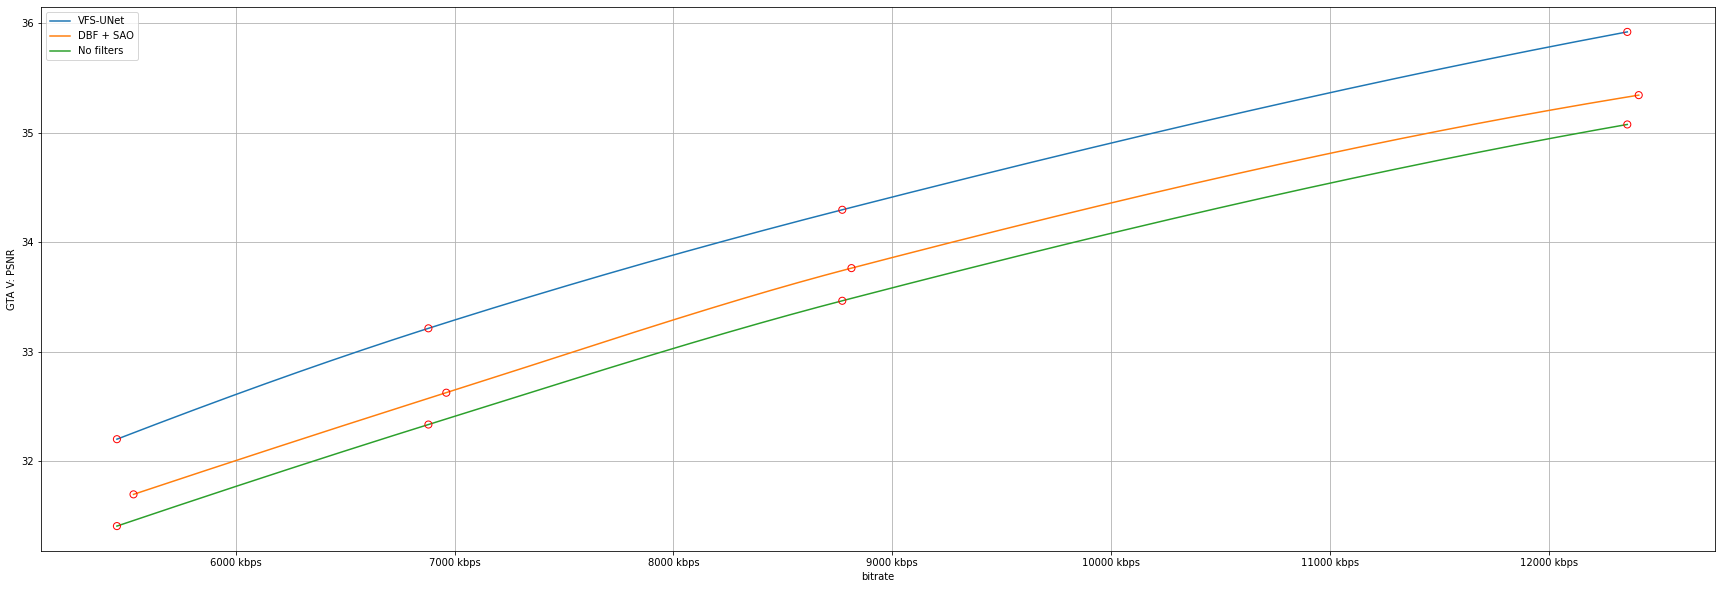

GTA V: PSNR: 0.5801572746296477
GTA V: PSNR BD-rate: -11.891492931856495


In [15]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/gtav-qp39"),
        torch.load("../trained_models/gtav-qp37"),
        torch.load("../trained_models/gtav-qp35"),
        torch.load("../trained_models/gtav-qp32"),
    ],
    "GTA V: PSNR",
    psnr
)

100%|██████████| 1564/1564 [00:13<00:00, 113.76it/s]


[tensor(0.9576, dtype=torch.float64), tensor(0.9661, dtype=torch.float64), tensor(0.9734, dtype=torch.float64), tensor(0.9814, dtype=torch.float64)]
[tensor(0.9502, dtype=torch.float64), tensor(0.9593, dtype=torch.float64), tensor(0.9682, dtype=torch.float64), tensor(0.9773, dtype=torch.float64)]
[tensor(0.9471, dtype=torch.float64), tensor(0.9567, dtype=torch.float64), tensor(0.9661, dtype=torch.float64), tensor(0.9760, dtype=torch.float64)]


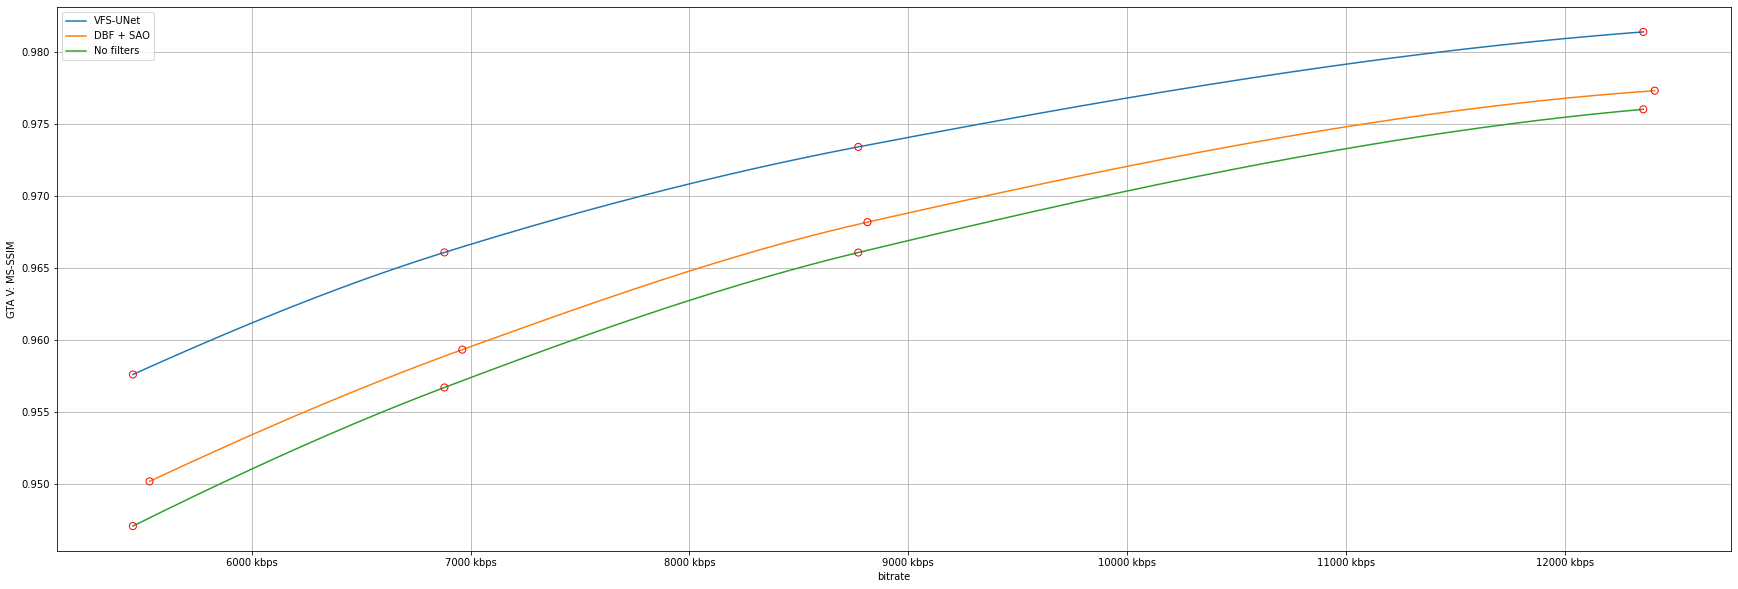

GTA V: MS-SSIM: 0.005920461725572124
GTA V: MS-SSIM BD-rate: -17.16744976143324


In [14]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/gta_v/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/gtav-qp39"),
        torch.load("../trained_models/gtav-qp37"),
        torch.load("../trained_models/gtav-qp35"),
        torch.load("../trained_models/gtav-qp32"),
    ],
    "GTA V: MS-SSIM",
    ms_ssim
)

100%|█████████▉| 12504/12505 [00:56<00:00, 221.15it/s]


[tensor(31.1828, dtype=torch.float64), tensor(32.1852, dtype=torch.float64), tensor(33.2392, dtype=torch.float64), tensor(34.7802, dtype=torch.float64)]
[tensor(30.5829, dtype=torch.float64), tensor(31.5304, dtype=torch.float64), tensor(32.7249, dtype=torch.float64), tensor(34.2397, dtype=torch.float64)]
[tensor(30.2837, dtype=torch.float64), tensor(31.2154, dtype=torch.float64), tensor(32.3864, dtype=torch.float64), tensor(33.9218, dtype=torch.float64)]


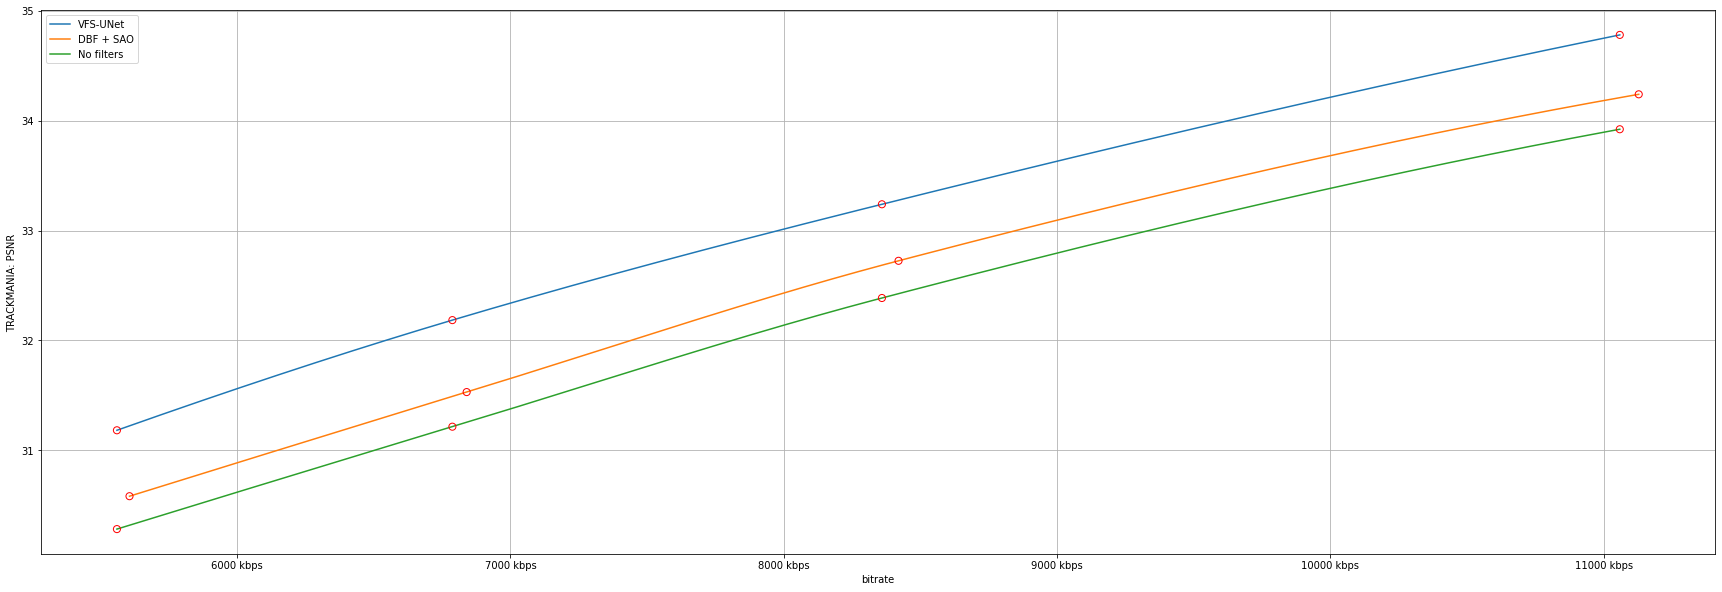

TRACKMANIA: PSNR: 0.6025924120697413
TRACKMANIA: PSNR BD-rate: -10.60494760851608


In [4]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/trackmania-qp39"),
        torch.load("../trained_models/trackmania-qp37"),
        torch.load("../trained_models/trackmania-qp35"),
        torch.load("../trained_models/trackmania-qp32"),
    ],
    "TRACKMANIA: PSNR",
    psnr
)

100%|█████████▉| 12504/12505 [02:03<00:00, 101.65it/s]


[tensor(0.9502, dtype=torch.float64), tensor(0.9534, dtype=torch.float64), tensor(0.9563, dtype=torch.float64), tensor(0.9596, dtype=torch.float64)]
[tensor(0.9420, dtype=torch.float64), tensor(0.9460, dtype=torch.float64), tensor(0.9508, dtype=torch.float64), tensor(0.9554, dtype=torch.float64)]
[tensor(0.9391, dtype=torch.float64), tensor(0.9434, dtype=torch.float64), tensor(0.9488, dtype=torch.float64), tensor(0.9540, dtype=torch.float64)]


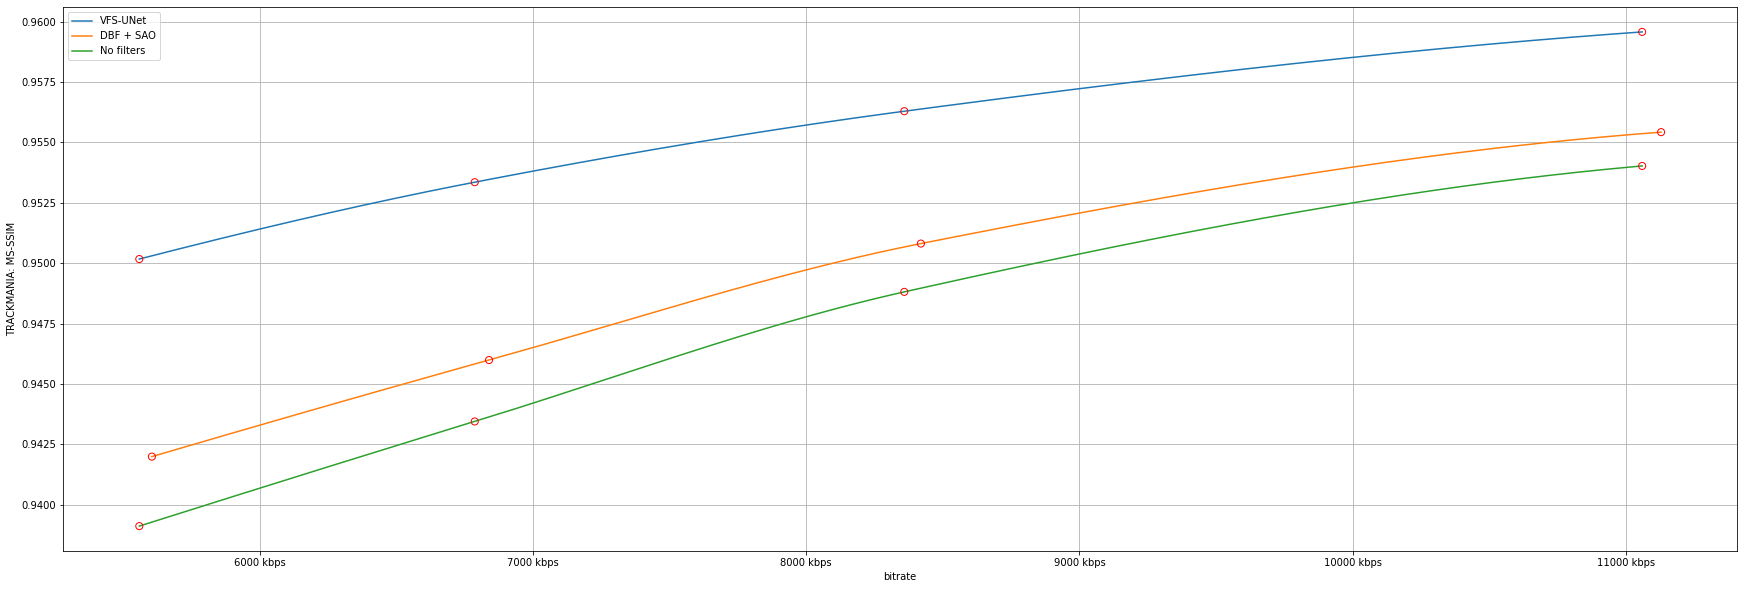

TRACKMANIA: MS-SSIM: 0.006222021690894054
TRACKMANIA: MS-SSIM BD-rate: -30.205011495437585


In [5]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/trackmania-qp39"),
        torch.load("../trained_models/trackmania-qp37"),
        torch.load("../trained_models/trackmania-qp35"),
        torch.load("../trained_models/trackmania-qp32"),
    ],
    "TRACKMANIA: MS-SSIM",
    ms_ssim
)

100%|██████████| 3483/3483 [00:14<00:00, 244.88it/s]


[tensor(32.2201, dtype=torch.float64), tensor(33.0180, dtype=torch.float64), tensor(34.2233, dtype=torch.float64), tensor(35.9122, dtype=torch.float64)]
[tensor(32.1159, dtype=torch.float64), tensor(32.9836, dtype=torch.float64), tensor(34.2553, dtype=torch.float64), tensor(35.7879, dtype=torch.float64)]
[tensor(31.9047, dtype=torch.float64), tensor(32.7580, dtype=torch.float64), tensor(33.9850, dtype=torch.float64), tensor(35.5313, dtype=torch.float64)]


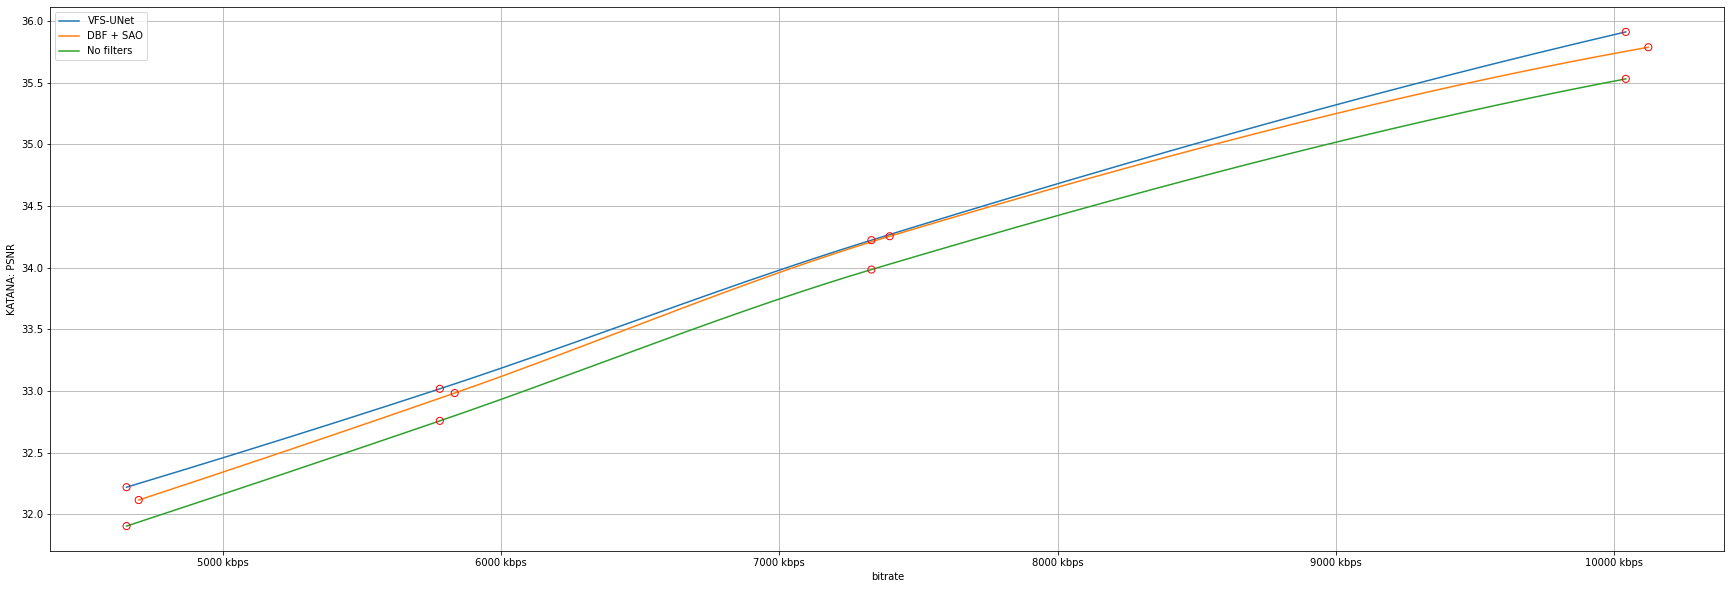

KATANA: PSNR: 0.06576840780323584
KATANA: PSNR BD-rate: -1.46845570848676


In [6]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/katana-qp39"),
        torch.load("../trained_models/katana-qp37"),
        torch.load("../trained_models/katana-qp35"),
        torch.load("../trained_models/katana-qp32"),
    ],
    "KATANA: PSNR",
    psnr
)

100%|██████████| 3483/3483 [00:30<00:00, 114.80it/s]


[tensor(0.9496, dtype=torch.float64), tensor(0.9543, dtype=torch.float64), tensor(0.9598, dtype=torch.float64), tensor(0.9652, dtype=torch.float64)]
[tensor(0.9445, dtype=torch.float64), tensor(0.9502, dtype=torch.float64), tensor(0.9566, dtype=torch.float64), tensor(0.9626, dtype=torch.float64)]
[tensor(0.9432, dtype=torch.float64), tensor(0.9490, dtype=torch.float64), tensor(0.9555, dtype=torch.float64), tensor(0.9619, dtype=torch.float64)]


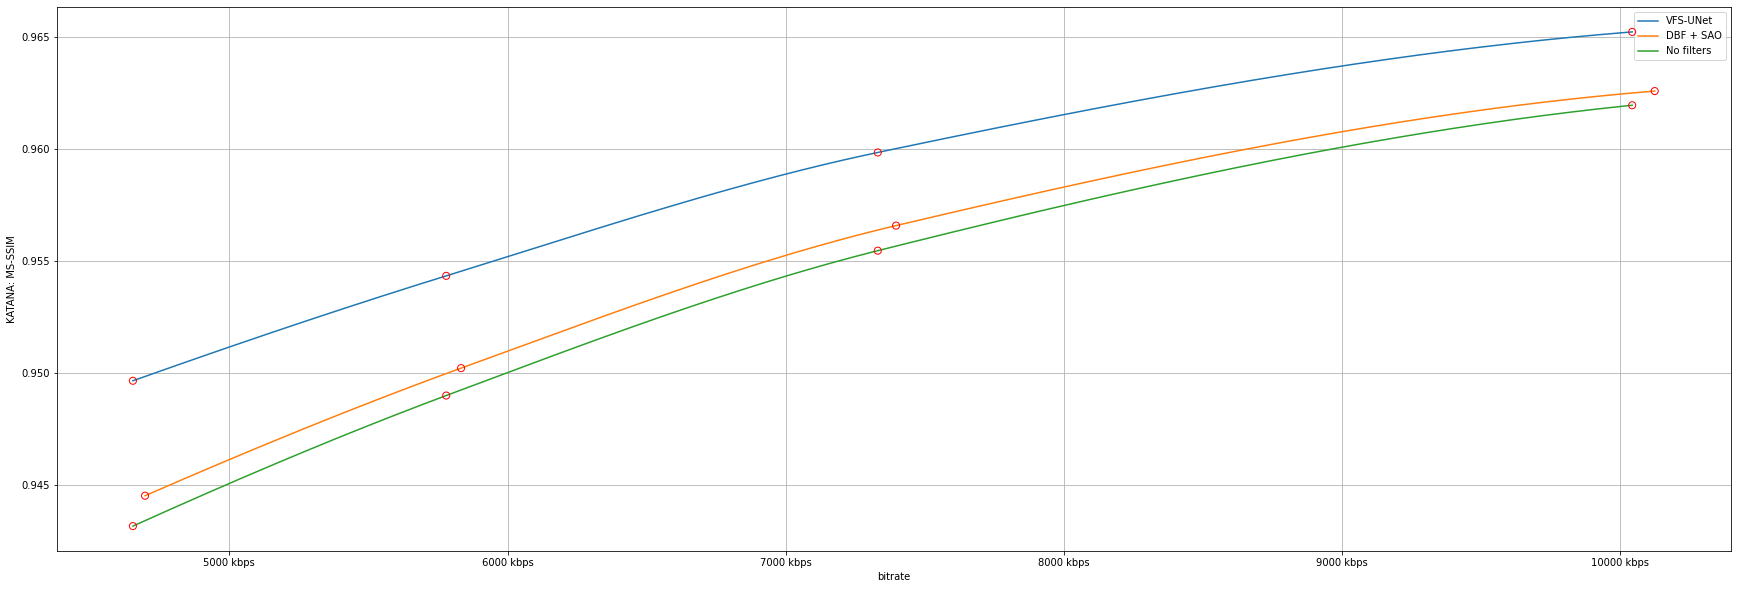

KATANA: MS-SSIM: 0.003812546724108507
KATANA: MS-SSIM BD-rate: -15.32496078169232


In [7]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/katana-qp39"),
        torch.load("../trained_models/katana-qp37"),
        torch.load("../trained_models/katana-qp35"),
        torch.load("../trained_models/katana-qp32"),
    ],
    "KATANA: MS-SSIM",
    ms_ssim
)

100%|██████████| 3483/3483 [00:12<00:00, 273.27it/s]


[tensor(31.8174, dtype=torch.float64), tensor(32.7175, dtype=torch.float64), tensor(33.7441, dtype=torch.float64), tensor(35.4039, dtype=torch.float64)]
[tensor(32.1159, dtype=torch.float64), tensor(32.9836, dtype=torch.float64), tensor(34.2553, dtype=torch.float64), tensor(35.7879, dtype=torch.float64)]
[tensor(31.9047, dtype=torch.float64), tensor(32.7580, dtype=torch.float64), tensor(33.9850, dtype=torch.float64), tensor(35.5313, dtype=torch.float64)]


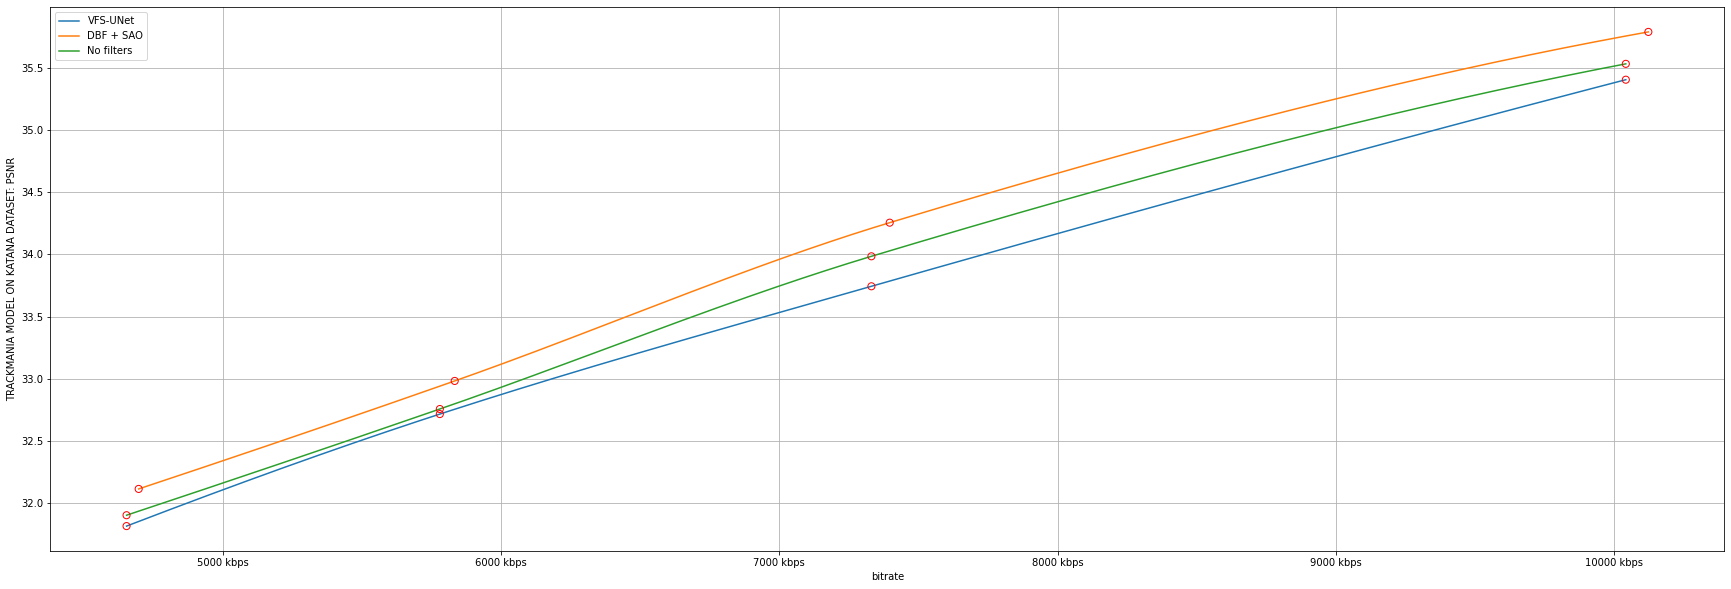

TRACKMANIA MODEL ON KATANA DATASET: PSNR: -0.3651363076289424
TRACKMANIA MODEL ON KATANA DATASET: PSNR BD-rate: 8.22334833581766


In [8]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/trackmania-qp39"),
        torch.load("../trained_models/trackmania-qp37"),
        torch.load("../trained_models/trackmania-qp35"),
        torch.load("../trained_models/trackmania-qp32"),
    ],
    "TRACKMANIA MODEL ON KATANA DATASET: PSNR",
    psnr
)

100%|██████████| 3483/3483 [00:30<00:00, 113.42it/s]


[tensor(0.9464, dtype=torch.float64), tensor(0.9517, dtype=torch.float64), tensor(0.9576, dtype=torch.float64), tensor(0.9634, dtype=torch.float64)]
[tensor(0.9445, dtype=torch.float64), tensor(0.9502, dtype=torch.float64), tensor(0.9566, dtype=torch.float64), tensor(0.9626, dtype=torch.float64)]
[tensor(0.9432, dtype=torch.float64), tensor(0.9490, dtype=torch.float64), tensor(0.9555, dtype=torch.float64), tensor(0.9619, dtype=torch.float64)]


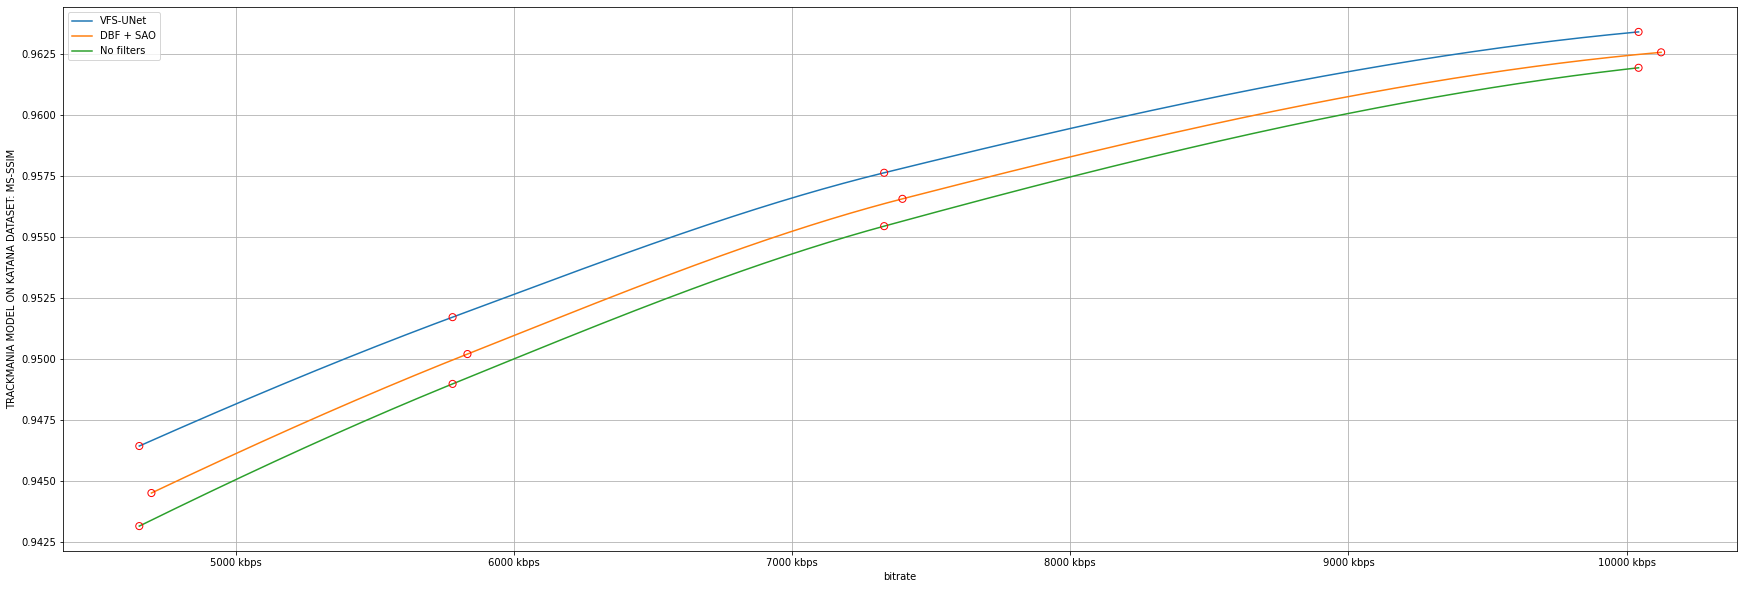

TRACKMANIA MODEL ON KATANA DATASET: MS-SSIM: 0.0014555296306382275
TRACKMANIA MODEL ON KATANA DATASET: MS-SSIM BD-rate: -6.097255924576139


In [9]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai08-nvme1n1p1/katana_zero/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/trackmania-qp39"),
        torch.load("../trained_models/trackmania-qp37"),
        torch.load("../trained_models/trackmania-qp35"),
        torch.load("../trained_models/trackmania-qp32"),
    ],
    "TRACKMANIA MODEL ON KATANA DATASET: MS-SSIM",
    ms_ssim
)

100%|█████████▉| 12504/12505 [00:52<00:00, 240.04it/s]


[tensor(30.7171, dtype=torch.float64), tensor(31.6741, dtype=torch.float64), tensor(32.7644, dtype=torch.float64), tensor(34.2913, dtype=torch.float64)]
[tensor(30.5829, dtype=torch.float64), tensor(31.5304, dtype=torch.float64), tensor(32.7249, dtype=torch.float64), tensor(34.2397, dtype=torch.float64)]
[tensor(30.2837, dtype=torch.float64), tensor(31.2154, dtype=torch.float64), tensor(32.3864, dtype=torch.float64), tensor(33.9218, dtype=torch.float64)]


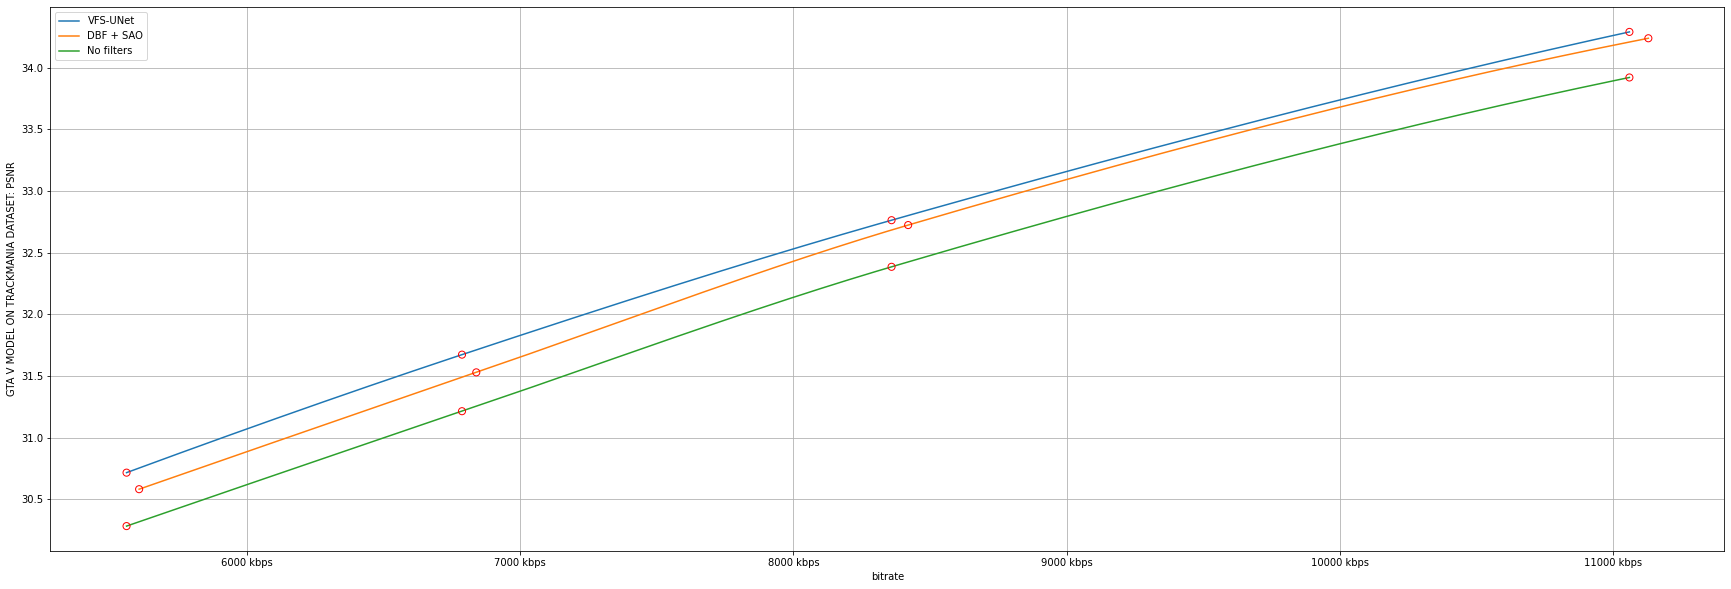

GTA V MODEL ON TRACKMANIA DATASET: PSNR: 0.11770029328313483
GTA V MODEL ON TRACKMANIA DATASET: PSNR BD-rate: -2.1696830974804904


In [10]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/gtav-qp39"),
        torch.load("../trained_models/gtav-qp37"),
        torch.load("../trained_models/gtav-qp35"),
        torch.load("../trained_models/gtav-qp32"),
    ],
    "GTA V MODEL ON TRACKMANIA DATASET: PSNR",
    psnr
)

100%|█████████▉| 12504/12505 [01:53<00:00, 110.20it/s]


[tensor(0.9477, dtype=torch.float64), tensor(0.9510, dtype=torch.float64), tensor(0.9546, dtype=torch.float64), tensor(0.9584, dtype=torch.float64)]
[tensor(0.9420, dtype=torch.float64), tensor(0.9460, dtype=torch.float64), tensor(0.9508, dtype=torch.float64), tensor(0.9554, dtype=torch.float64)]
[tensor(0.9391, dtype=torch.float64), tensor(0.9434, dtype=torch.float64), tensor(0.9488, dtype=torch.float64), tensor(0.9540, dtype=torch.float64)]


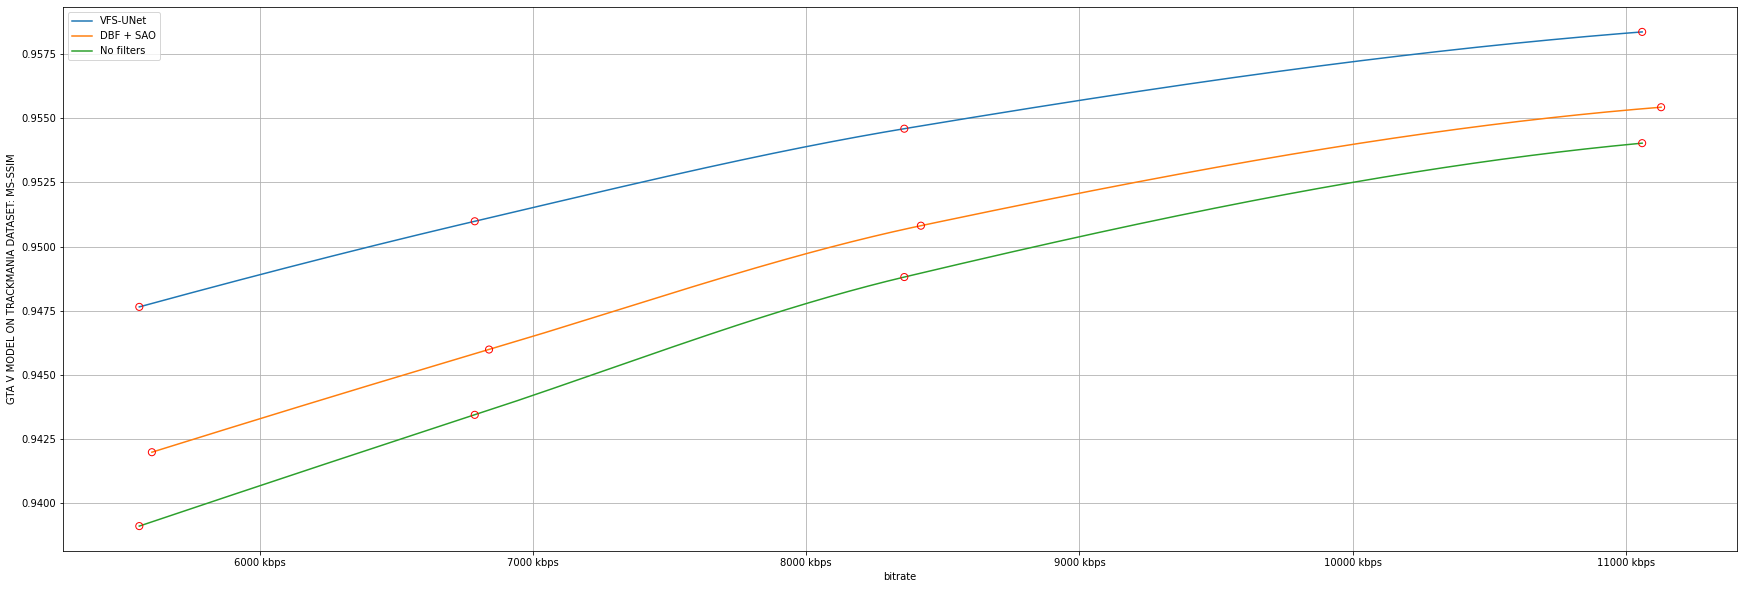

GTA V MODEL ON TRACKMANIA DATASET: MS-SSIM: 0.004326104156145184
GTA V MODEL ON TRACKMANIA DATASET: MS-SSIM BD-rate: -20.67821758583801


In [11]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai09-nvme1n1p1/jpawlowski/trackmania/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/gtav-qp39"),
        torch.load("../trained_models/gtav-qp37"),
        torch.load("../trained_models/gtav-qp35"),
        torch.load("../trained_models/gtav-qp32"),
    ],
    "GTA V MODEL ON TRACKMANIA DATASET: MS-SSIM",
    ms_ssim
)

100%|██████████| 1585/1585 [00:06<00:00, 252.35it/s]


[tensor(33.5787, dtype=torch.float64), tensor(34.7083, dtype=torch.float64), tensor(35.8619, dtype=torch.float64), tensor(37.6012, dtype=torch.float64)]
[tensor(32.8683, dtype=torch.float64), tensor(33.8699, dtype=torch.float64), tensor(35.1205, dtype=torch.float64), tensor(36.7335, dtype=torch.float64)]
[tensor(32.5151, dtype=torch.float64), tensor(33.5022, dtype=torch.float64), tensor(34.7258, dtype=torch.float64), tensor(36.3554, dtype=torch.float64)]


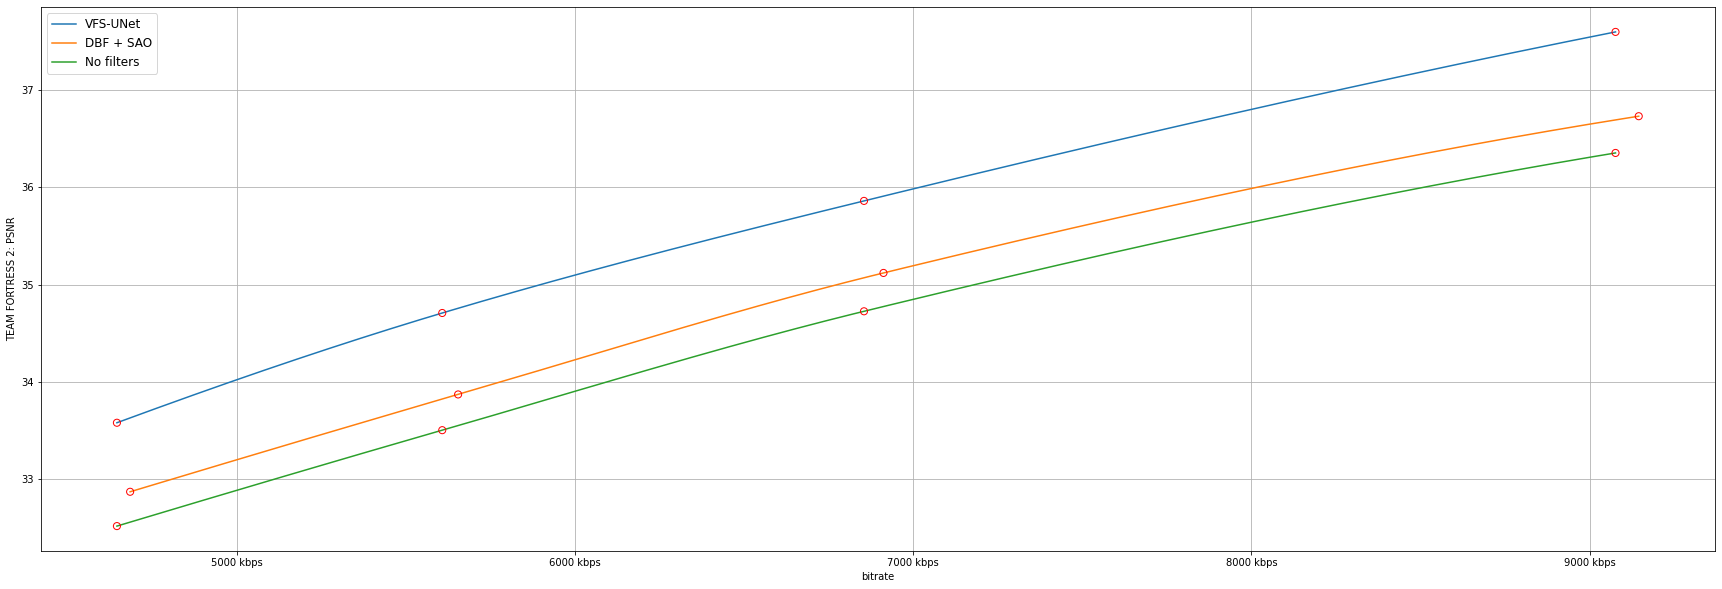

TEAM FORTRESS 2: PSNR: 0.826048293184606
TEAM FORTRESS 2: PSNR BD-rate: -12.987573712483124


In [20]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/tf2-qp39"),
        torch.load("../trained_models/tf2-qp37"),
        torch.load("../trained_models/tf2-qp35"),
        torch.load("../trained_models/tf2-qp32"),
    ],
    "TEAM FORTRESS 2: PSNR",
    psnr
)

100%|██████████| 1585/1585 [00:13<00:00, 117.66it/s]


[tensor(0.9685, dtype=torch.float64), tensor(0.9740, dtype=torch.float64), tensor(0.9788, dtype=torch.float64), tensor(0.9844, dtype=torch.float64)]
[tensor(0.9593, dtype=torch.float64), tensor(0.9656, dtype=torch.float64), tensor(0.9724, dtype=torch.float64), tensor(0.9793, dtype=torch.float64)]
[tensor(0.9555, dtype=torch.float64), tensor(0.9624, dtype=torch.float64), tensor(0.9697, dtype=torch.float64), tensor(0.9775, dtype=torch.float64)]


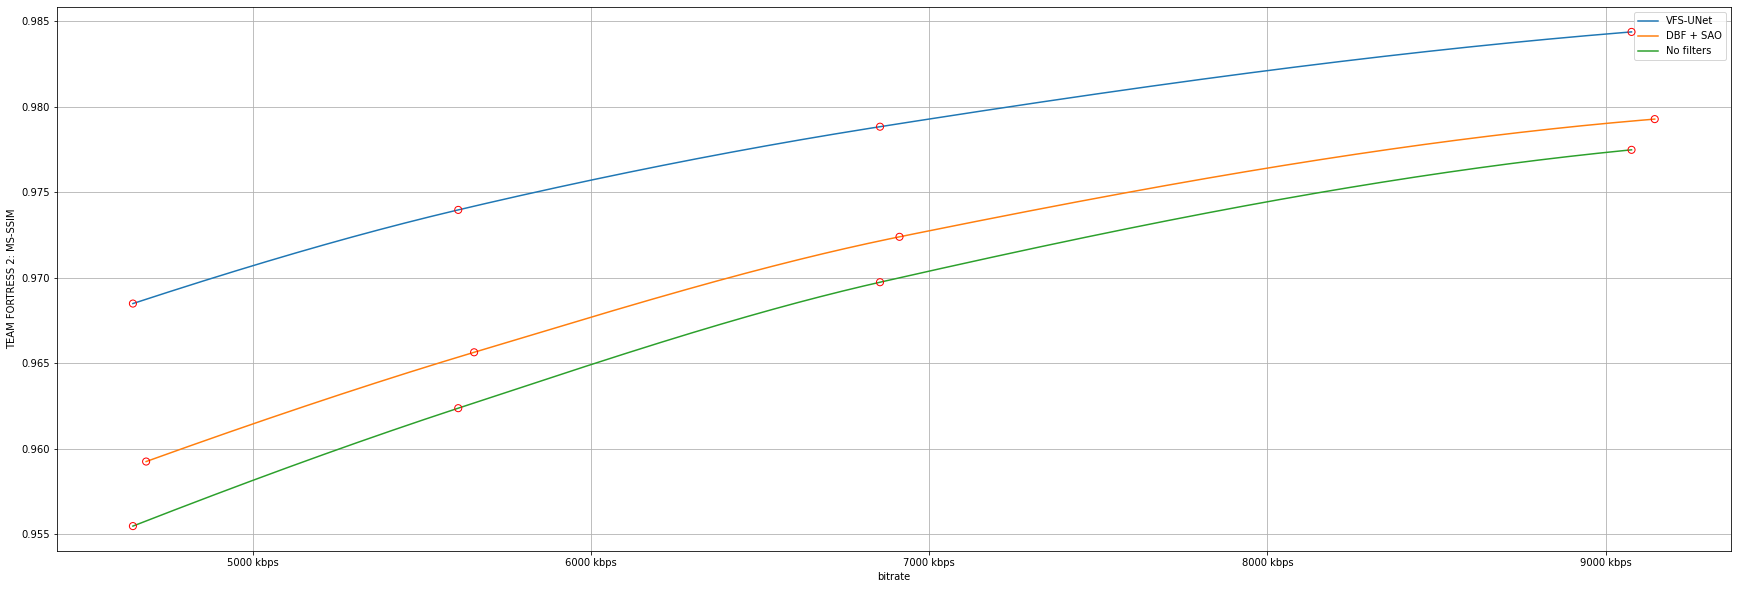

TEAM FORTRESS 2: MS-SSIM: 0.007246499000627902
TEAM FORTRESS 2: MS-SSIM BD-rate: -23.41393907986069


In [13]:
process_bd_rates(
    [
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_qp=39/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_qp=37/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_qp=35/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_qp=32/"),
    ],
    [
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_deblocked_qp=39/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_deblocked_qp=37/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_deblocked_qp=35/"),
        Path("/mnt/nfs_svtai10-nvme1n1p1/jpawlowski/tf2/valid/ai_hevc_deblocked_qp=32/"),
    ],
    [
        torch.load("../trained_models/tf2-qp39"),
        torch.load("../trained_models/tf2-qp37"),
        torch.load("../trained_models/tf2-qp35"),
        torch.load("../trained_models/tf2-qp32"),
    ],
    "TEAM FORTRESS 2: MS-SSIM",
    ms_ssim
)
